In [143]:
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch import nn
from model.CNN_model import *
from model.Function import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [144]:
model = CNN_model()
if torch.cuda.is_available():
    model = model.cuda()
model.load_state_dict(torch.load("./model/save/CNN_1.pt"))
print(model)

CNN_model(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [145]:
images = DataLoader(image_data("./data/Examples/"), batch_size=5)
images = next(iter(images))

In [146]:
def hook_feature(module, input, output):
    features_blobs.append(output.data.numpy())
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

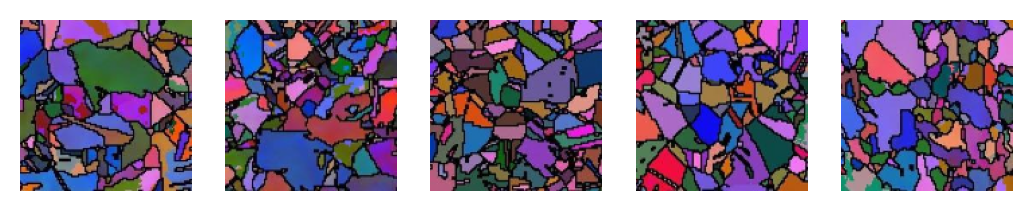

In [147]:
plt.figure(dpi=200)
for i in range(5):
    img = images[i]
    #显示原始图片
    npimg = img.numpy()
    #maxValue=npimg.max()
    array1=npimg*255 #/maxValue#normalize，将图像数据扩展到[0,255]
    mat=np.uint8(array1)
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.box()
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()

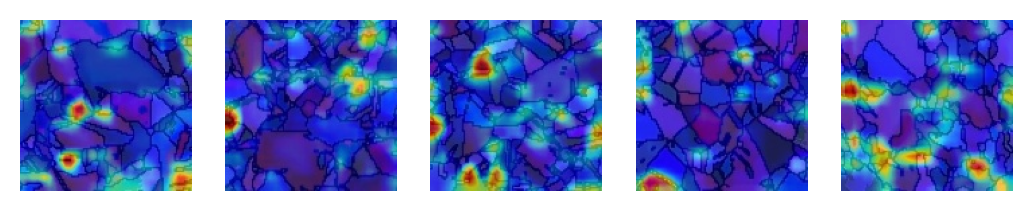

In [149]:
plt.figure(dpi=200)
for i in range(5):
    img = images[i]
    img_np = img.numpy()
    img_np = np.transpose(img_np, [1, 2, 0])
    height, width, _ = img_np.shape

    #gradcam实现
    model.eval()
    model = model.cpu()
    # hook the feature extractor
    finalconv_name = 'features'
    features_blobs = []

    model._modules.get(finalconv_name).register_forward_hook(hook_feature)

    # load test image
    img = torch.unsqueeze(img, dim=0)#/255
    logit, _ = model(img)

    # get the softmax weight
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-4].data.cpu().numpy())

    h_x =  params[-3]# * params[-2].squeeze(-2)
    probs, idx = h_x.sort(0, True)
    probs = probs.detach().numpy()
    idx = idx.detach().numpy()

    # generate class activation mapping for the top1 prediction
    CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

    # render the CAM and output

    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.6 + img_np * 0.4 * 255
    cv2.imwrite('CAM.jpg', result)
    img_CAM = mpimg.imread("CAM.jpg")
    plt.subplot(1, 5, i+1)
    plt.imshow(img_CAM)
    plt.box()
    plt.xticks([])
    plt.yticks([])